In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import netCDF4
import skimage.feature
import scipy.ndimage as ndi

from searchdude import searchtc
from datadude import readfile
from datadude import writetc
from winddude import windmax
from utils import str_to_datetime, print_current_step, datetime_to_str

import datetime
import os

In [116]:
# sharpen the mix
initime = "2013-06-01T000000Z"
endtime = "2013-12-01T000000Z"

member = "01"
exp = "25_40"
indir = "/cluster/scratch/enjan/sim_13k/2013_" + member + "_" + exp + "/remap/"
indir2 = "/cluster/scratch/enjan/sim_13k/2013_" + member + "_" + exp + "/remap/"
inbase = "REMAP_NWP_LAM_DOM01_"
inbase2 = "REMAP_NWP_LAM_PL_T_DOM01_"
outname = "TC_" + member + "_" + exp + ".txt"


tc_params = dict(
    slpdis=50000,  # minimum distance between two slp minima
    maxlat=45,  # maximum latitude that is considered in degrees
    vormin=10 ** (-5),  # minimum vorticity to pass as TC
    temdif=1,  # temperature difference of warm core
    temdis=200000,  # distance at which location is considered "environment"
    winddis=100000,  # distance within which to look for wind maximum
    maxhgt=3000,  # maximum height where mind maximum is searched
    res=0.125,  # resolution in degrees
)

# to all kinds of trix

curr_datetime = str_to_datetime(initime)
end_datetime = str_to_datetime(endtime)

fname = os.path.join(indir, inbase + datetime_to_str(curr_datetime) + ".nc")
dataset = netCDF4.Dataset(fname)

tc_data = dict(
    slp=dataset.variables["pres_msl"][:],
    vor=dataset.variables["vor"][:],
    u=dataset.variables["u"][:],
    v=dataset.variables["v"][:],
    hgt=dataset.variables["z_mc"][:],
    lon=dataset.variables["lon"][:],
    lat=dataset.variables["lat"][:],
)
dataset.close()

fname2 = os.path.join(indir2, inbase2 + datetime_to_str(curr_datetime) + ".nc")
dataset2 = netCDF4.Dataset(fname2)
tc_data["tem"] = dataset2.variables["temp"][:]
dataset2.close()

In [117]:
def filter_out(tcloc, slp, min_dist=2):
    ni = tcloc.shape[0]
    nj = tcloc.shape[1]

    for i in range(0, ni):
        for j in range(0, nj):
            for ii in range(-min_dist, min_dist + 1):
                for jj in range(-min_dist, min_dist + 1):
                    if ii == 0 and jj == 0:
                        continue

                    indi = i + ii
                    indj = j + jj

                    # adjust for out of bounds indices
                    if indi < 0:
                        indi = indi + ni
                    if indi >= ni:
                        indi = indi - ni
                    if indj < 0:
                        indj = indj + nj
                    if indj >= nj:
                        indj = indj - nj

                    # check for minimum
                    if slp[j, i] > slp[indj, indi]:
                        tcloc[j, i] = 0

In [118]:
def plot_tcloc(tcloc,title,**kwargs):
    # make a color map of fixed colors
    plt.figure(**kwargs)
    cmap = colors.ListedColormap(['white', 'red'])
    bounds=[0,0.5,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    img = plt.imshow(tcloc, interpolation='nearest', origin='upper',
                    cmap=cmap, norm=norm)

    plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 0.5, 1])
    plt.title(title)
    plt.show()

    
def plot_2d(data,title):
    plt.figure()
    plt.imshow(data,origin='upper')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [119]:
N = 25
img = np.zeros((N, N))
img[0,0] = 20
img[3, 4] = 1
img[3, 2] = 1.5
img[16, 19] = 10
img[12, 2] = 1.5
img[24,0] = 10

img = -img
data = np.ones((N,N))
jdata = np.ones((N,N))

In [120]:
plot_2d(img,title="random image")
plot_tcloc(data,title=" Data")

In [121]:
cond = img > -1
data[cond] = 0
jdata[cond] = 0
plot_tcloc(data,title="Threshold Data")

In [122]:
N = 25
img = np.zeros((N, N))
img[0,0] = 10
img[3, 4] = 1
img[3, 2] = 1.5
img[16, 19] = 10
img[12, 2] = 1.5
img[24,0] = 20

img = -img
data = np.ones((N,N))
jdata = np.ones((N,N))

cond = img > -1
data[cond] = 0
jdata[cond] = 0

min_dist=4

jan_min_dist=4

filter_out(data,img,min_dist=min_dist)
mins = skimage.feature.peak_local_max(-img,min_distance=jan_min_dist,indices=False,exclude_border=False)
jdata[~mins] = 0

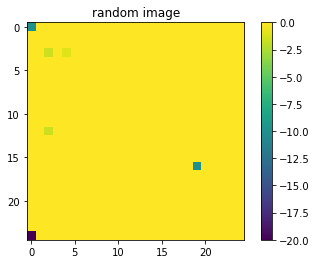

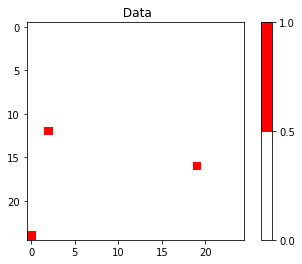

In [114]:
plot_2d(img,title="random image")
plot_tcloc(data,title=" Data")
plot_tcloc(jdata,title="Jan Data")